# Generate Figures for the Paper
Raw data is in the `data` directory.
No data from outside of this directory should be used in figure generation.
Caching the data in the `data` directory makes it easy to recover figures later.

## Create an Environment

1. `conda env create --file py/conda-env.yaml`
2. `conda activate protopnext-neurips-paper`
3. `pip install -r py/requirements.txt`

## Data

- `run-training-report.csv` - summary training information for each run that is a part of the protopnext/neurips-experiments project. Row key is `run_id`.
- `sweep-report.csv` - overview of each sweep, including the objective and model backbone. Row key is `sweep_id`.
- `eval/*.csv` - results of applying best models from training runs to test set. This is a subset of trained models. Files are named by `sweep_id`, and row key is `run_id`.

### Copying Data

These files are available in `/usr/xtmp/ppnxt/neurips2024/live/aggregates`.
To update one of these files, simply `scp` it into this repo.
In your commit message for the data change, please be sure to mention why you are pulling new data.

Example Command: `scp compsci-login.cs.duke.edu:/usr/xtmp/ppnxt/neurips2024/live/aggregates/run_report_latest.csv data/`

# Environment Setup

In [30]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import numpy as np
from pathlib import Path
import pandas as pd
%matplotlib inline

## Visualization

In [369]:
matplotlib.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "axes.titlesize": 14,
        "axes.titleweight": "bold",
        "axes.labelsize" : 10,
        "axes.labelweight" : "normal",
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "figure.dpi": 200, # for notebook visualization
        "savefig.dpi": 600,
        "lines.linewidth": .6,
        "legend.fontsize": 6,
        "axes.prop_cycle": matplotlib.cycler(color=['80c2e4', 'f6d099', '85d992', 'f5f597']),
    }
)

In [32]:
def stylize(string):
    if pd.isna(string):
        return ''
    if string.startswith("resnet"):
        return "ResNet-" + string[6:]
    if string.startswith("vgg"):
        return "VGG-" + string[3:]
    if string.startswith("densenet"):
        return "DenseNet-" + string[8:]
    if string == 'cos':
        return "Cosine"
    if string == 'l2':
        return "Euclidean"
    if string == 'deformable':
        return "Deformable"
    if string == 'protopnet':
        return "ProtoPNet"
    if string == 'vanilla':
        return "ProtoPNet"
    if 'acc_proto_score' in string:
        return "A-PS"
    if 'accuracy' in string:
        return "Acc"
    if 'prototype_score' in string:
        return "PS"
    
    if string.startswith("eval") and string.endswith("@best_step"):
        core = string[5:-10]
        return core.replace("_", " ").title().replace("Gold", "")
    return string

def style_in_01(flt):
    return f"{100*flt:.1f}"

def style_df(df):
    df = df.copy()
    df = df.rename(columns=stylize)
    for col in df.columns:
        if (df[col].dtype == np.float64 or df[col].dtype == np.float32 or df[col].dtype == np.float16 or df[col].dtype == float):
            if df[col].max() <= 1.0 and df[col].min() >= 0.0:
                df[col] = df[col].apply(style_in_01)
            else:
                pass
        elif df[col].dtype == np.int64:
            df[col] = df[col].apply(lambda x: f"{x:,}")
        else:
            df[col] = df[col].apply(stylize)
    return df

In [33]:
backbone_marker = {
    'deformable': 'x',
    'vanilla': '.',
}

backbone_dist_colors = {
    'vanilla': {
        'cos': 'blue',
        'l2': 'green',
    },
    'deformable': {'cos': 'orange'},
}

## Datasets

### Runs

In [198]:
runs = pd.read_csv('data/run_report_full.csv')
runs_meta = pd.read_csv('data/runs_wandb_meta.csv')

runs = runs.merge(runs_meta, on='run_id')
runs.head(3).pipe(display)
runs.shape

run_id                                               name  sweep_id  \
0  jn30hh39  cc--1.4E+00_im-False_jlss-5_kft-8_lc-8.3E-04_l...  87hmid8s   
1  uv5x7rzf  cc--5.8E-01_im-False_jlss-9_kft-6_lc-2.6E-05_l...  o12zm01u   
2  63qafmn0  cc--1.7E+00_im-False_jlss-9_kft-5_lc-1.3E-05_l...  87hmid8s   

             timestamp                                          save_path  \
0  2024-05-21 10:18:39  /usr/xtmp/ppnxt/neurips2024/live/artifacts/87h...   
1  2024-05-21 08:24:15  /usr/xtmp/ppnxt/neurips2024/live/artifacts/o12...   
2  2024-05-21 09:10:38  /usr/xtmp/ppnxt/neurips2024/live/artifacts/87h...   

                                                 url objective  \
0  https://wandb.ai/protopnext/neurips-experiment...  accuracy   
1  https://wandb.ai/protopnext/neurips-experiment...  accuracy   
2  https://wandb.ai/protopnext/neurips-experiment...  accuracy   

   objective_value  multiplier  step@best_step  ...  eval.accu@best_step  \
0              NaN         1.0             146  ...                  NaN   
1              NaN         1.0              32  ...                  NaN   
2              NaN         1.0              83  ...                  NaN   

   Unnamed: 0            t  code_path  framework    start_time  cli_version  \
0           1  [1, 41, 55]        NaN      torch  1.716293e+09       0.16.6   
1           1  [1, 41, 55]        NaN      torch  1.716292e+09       0.16.6   
2           1  [1, 41, 55]        NaN      torch  1.716288e+09       0.16.6   

   is_jupyter_run  python_version  is_kaggle_kernel  
0           False          3.8.18             False  
1           False          3.8.18             False  
2           False          3.8.18             False  

[3 rows x 44 columns]

(4068, 44)

In [199]:
# TODO normalize accuracies
runs[['multiplier', 'eval.accu@best_step', 'eval.accuracy@best_step']]

def gold_acc(row):
    if row['multiplier'] == 0.01:
        assert pd.isna(row['eval.accuracy@best_step']), row
        return row['eval.accu@best_step'] * row['multiplier']
    elif row['multiplier'] == 1.0:
        assert pd.isna(row['eval.accu@best_step']), row
        return row['eval.accuracy@best_step']
    else:
        raise ValueError(f'bad multiplier {row["multiplier"]} in {row}')
    
runs['eval.gold_accuracy@best_step'] = runs.apply(gold_acc, axis=1)


# FIXME
acc_ts = pd.to_datetime(runs['timestamp'])

runs['rel_start_time_hrs'] = (acc_ts - acc_ts.min()).dt.total_seconds()/60/60

assert runs['eval.gold_accuracy@best_step'].isna().sum() == 0

### Sweeps

In [200]:
sweeps = pd.read_csv('data/sweep_report_latest.csv')
sweeps.head(3).pipe(display)
sweeps.shape

description      entity method  \
0  Run a sweep for the vanilla model to validate ...  protopnext  bayes   
1  Run a sweep for the vanilla model to validate ...  protopnext  bayes   
2  Run a sweep for the vanilla model to validate ...  protopnext  bayes   

                                                name  \
0  vanilla-no-schedule-adjustment-preflight-vgg16...   
1  vanilla-no-schedule-adjustment-preflight-dense...   
2                     deformable-dogs-vgg19-acc_only   

                               program              project     backbone  \
0     training/sweeps/sweep-vanilla.py  neurips-experiments        vgg16   
1     training/sweeps/sweep-vanilla.py  neurips-experiments  densenet121   
2  training/sweeps/sweep-deformable.py  neurips-experiments        vgg19   

     metric  sweep_id                                                url  \
0  accuracy  cjsrksy4  https://wandb.ai/protopnext/neurips-experiment...   
1  accuracy  hc6d3t1s  https://wandb.ai/protopnext/neurips-experiment...   
2  accuracy  87hmid8s  https://wandb.ai/protopnext/neurips-experiment...   

  best_run_id  
0    fm0pk76w  
1    26xdv68t  
2    cxut1pcv

(51, 11)

In [201]:
def model_from_program(row):
    if row['program'].endswith('sweep-vanilla-cos.py'):
        return 'vanilla', 'cos'
    if row['program'].endswith('sweep-vanilla.py'):
        return 'vanilla', 'l2'
    if row['program'].endswith('sweep-deformable.py'):
        return 'deformable', 'cos'
    
    raise ValueError(f'bad program {row["program"]}')

def schedule_adjustment(row):
    # FIXME - this should be exported
    if row['sweep_id'] in ('hemvex0j', '25ctf1nx', 'dowk7go0', 'gecosh73', 'wvr435og', 'hm473f3b'):
        return '30x'
    else:
        return '1x'
    

cancelled_sweeps = {'h7qe2n3l', 'gqtjahw7', '7hdrzqf0', 'yvm2hh5c', 'lzu16a9k', '8axggb8o', '1uorruu9', '1tio1nx9', 'gwel80qe', 'qv984pfp', 'pvbnaver', 'ui19nbue', 'u7289lg3', '4bgibal3', '79yy37g8', '3qznk856'}

__df = sweeps.apply(model_from_program, axis=1, result_type='expand')

sweeps = sweeps[~sweeps['sweep_id'].isin(cancelled_sweeps)]
sweeps['arch'], sweeps['distance'] = __df[0], __df[1]

sweeps['schedule_adjust'] = sweeps.apply(schedule_adjustment, axis=1)
sweeps = sweeps[sweeps['schedule_adjust'] == '1x']

sweeps['dataset'] = sweeps['name'].str.lower().str.contains('dogs').apply(lambda x: 'dogs' if x else 'cub200')
sweeps.head(3)[['arch', 'distance', 'name', 'schedule_adjust']]

arch distance                                               name  \
0     vanilla       l2  vanilla-no-schedule-adjustment-preflight-vgg16...   
1     vanilla       l2  vanilla-no-schedule-adjustment-preflight-dense...   
2  deformable      cos                     deformable-dogs-vgg19-acc_only   

  schedule_adjust  
0              1x  
1              1x  
2              1x

### Test Results

In [202]:
eval_cub200 = pd.DataFrame()

for file in Path('data/eval').glob('*.csv'):
    eval_cub200 = pd.concat([eval_cub200, pd.read_csv(file)])

eval_cub200.head(3).pipe(display)
eval_cub200.shape

run_id                                         model_path  val.accuracy  \
0  7lspcd1z  /usr/xtmp/ppnxt/neurips2024/live/artifacts/aed...      0.584175   
1  95p58vzm  /usr/xtmp/ppnxt/neurips2024/live/artifacts/aed...      0.594276   
2  9sm1yw8u  /usr/xtmp/ppnxt/neurips2024/live/artifacts/aed...      0.611111   

   val.prototype_stability  val.prototype_consistency  val.prototype_sparsity  \
0                 0.490833                       0.44                1.104570   
1                 0.664038                       0.81                0.444725   
2                 0.482500                       0.50                1.193758   

   val.n_unique_proto_parts  val.n_unique_protos  val.prototype_score  \
0                    1566.0                174.0             0.643611   
1                    3138.0                436.0             0.639588   
2                    1449.0                161.0             0.660833   

   val.acc_proto_score  ...  test.prototype_score  test.acc_proto_score  \
0             0.375982  ...              0.503209              0.287387   
1             0.380092  ...              0.469498              0.267810   
2             0.403843  ...              0.503004              0.303417   

   accuracy  prototype_stability  prototype_consistency  prototype_sparsity  \
0       NaN                  NaN                    NaN                 NaN   
1       NaN                  NaN                    NaN                 NaN   
2       NaN                  NaN                    NaN                 NaN   

   n_unique_proto_parts  n_unique_protos  prototype_score  acc_proto_score  
0                   NaN              NaN              NaN              NaN  
1                   NaN              NaN              NaN              NaN  
2                   NaN              NaN              NaN              NaN  

[3 rows x 26 columns]

(3003, 26)

In [203]:
eval_dogs = pd.DataFrame()

for file in Path('data/eval-dogs').glob('*.csv'):
    eval_dogs = pd.concat([eval_dogs, pd.read_csv(file)])

eval_dogs.shape

(187, 18)

In [204]:
eval = pd.concat([eval_cub200, eval_dogs])
eval.shape

(3190, 26)

### Merging

#### All Runs

In [205]:
runsXeval = pd.merge(runs, eval, on='run_id', suffixes=('_run', '_eval'), how='left')
display(runsXeval.columns)
runsXeval.shape

Index(['run_id', 'name', 'sweep_id', 'timestamp', 'save_path', 'url',
       'objective', 'objective_value', 'multiplier', 'step@best_step',
       'eval.accuracy@best_step', 'hp.l1_coef', 'hp.k_for_topk',
       'hp.cluster_coef', 'hp.lr_multiplier', 'hp.separation_coef',
       'hp.num_addon_layers', 'hp.phase_multiplier', 'hp.joint_lr_step_size',
       'hp.orthogonality_loss', 'hp.post_project_phases',
       'hp.prototype_dimension', 'hp.interpretable_metrics',
       'hp.pre_project_phase_len', 'hp.num_prototypes_per_class',
       'hp.latent_dim_multiplier_exp', 'hp.num_warm_pre_offset_epochs',
       'eval.n_unique_protos@best_step', 'eval.n_unique_proto_parts@best_step',
       'eval.prototype_sparsity@best_step',
       'eval.prototype_stability@best_step',
       'eval.prototype_consistency@best_step',
       'eval.prototype_score@best_step', 'eval.acc_proto_score@best_step',
       'eval.accu@best_step', 'Unnamed: 0', 't', 'code_path', 'framework',
       'start_time', 'cli

(4074, 71)

In [206]:
runsXevalXsweeps = runsXeval.merge(sweeps, on='sweep_id', suffixes=('_run', '_sweep')).set_index(['dataset', 'metric', 'arch', 'distance', 'backbone'])  
runsXevalXsweeps.groupby(['dataset', 'metric', 'arch', 'distance', 'backbone', 'schedule_adjust'], dropna=False).count().pipe(display)
runsXevalXsweeps = runsXevalXsweeps.sort_index()

run_id  \
dataset metric          arch       distance backbone    schedule_adjust           
cub200  acc_proto_score deformable cos      densenet161 1x                  111   
                                            resnet50    1x                  263   
                                            vgg19       1x                  150   
                        vanilla    cos      densenet161 1x                  137   
                                            resnet50    1x                  168   
                                            vgg19       1x                  136   
        accuracy        deformable cos      densenet121 1x                  163   
                                            densenet161 1x                  123   
                                            resnet34    1x                  171   
                                            resnet50    1x                  160   
                                            vgg16       1x                  173   
                                            vgg19       1x                  166   
                        vanilla    cos      densenet121 1x                  138   
                                            densenet161 1x                  136   
                                            resnet34    1x                  149   
                                            resnet50    1x                  178   
                                            vgg16       1x                  148   
                                            vgg19       1x                  132   
                                   l2       densenet121 1x                  117   
                                            densenet161 1x                  117   
                                            resnet34    1x                  140   
                                            resnet50    1x                  157   
                                            vgg16       1x                  118   
                                            vgg19       1x                  117   
dogs    accuracy        deformable cos      densenet161 1x                   45   
                                            resnet50    1x                   53   
                                            vgg19       1x                   53   
                        vanilla    cos      densenet161 1x                   42   
                                            resnet50    1x                   38   
                                            vgg19       1x                   39   

                                                                         name_run  \
dataset metric          arch       distance backbone    schedule_adjust             
cub200  acc_proto_score deformable cos      densenet161 1x                    111   
                                            resnet50    1x                    263   
                                            vgg19       1x                    150   
                        vanilla    cos      densenet161 1x                    137   
                                            resnet50    1x                    168   
                                            vgg19       1x                    136   
        accuracy        deformable cos      densenet121 1x                    163   
                                            densenet161 1x                    123   
                                            resnet34    1x                    171   
                                            resnet50    1x                    160   
                                            vgg16       1x                    173   
                                            vgg19       1x                    166   
                        vanilla    cos      densenet121 1x                    138   
                                            densenet161 1x                    136   
                                            resnet34    

#### Only On Best

In [207]:
runsXevalXsweeps_atbest = runsXeval.merge(sweeps, left_on='run_id', right_on='best_run_id', suffixes=('_run', '_sweep'))

runsXevalXsweeps_atbest = runsXevalXsweeps_atbest.set_index(['dataset', 'metric', 'arch', 'distance', 'backbone'])
runsXevalXsweeps_atbest.groupby(['dataset', 'metric', 'arch', 'distance', 'backbone', 'schedule_adjust'], dropna=False).count()

run_id  \
dataset metric          arch       distance backbone    schedule_adjust           
cub200  acc_proto_score deformable cos      densenet161 1x                    1   
                                            resnet50    1x                    1   
                                            vgg19       1x                    1   
                        vanilla    cos      densenet161 1x                    1   
                                            resnet50    1x                    1   
                                            vgg19       1x                    1   
        accuracy        deformable cos      densenet121 1x                    1   
                                            densenet161 1x                    1   
                                            resnet34    1x                    1   
                                            resnet50    1x                    1   
                                            vgg16       1x                    1   
                                            vgg19       1x                    1   
                        vanilla    cos      densenet121 1x                    1   
                                            densenet161 1x                    1   
                                            resnet34    1x                    1   
                                            resnet50    1x                    1   
                                            vgg16       1x                    1   
                                            vgg19       1x                    1   
                                   l2       densenet121 1x                    1   
                                            densenet161 1x                    1   
                                            resnet34    1x                    1   
                                            resnet50    1x                    1   
                                            vgg16       1x                    1   
                                            vgg19       1x                    1   
dogs    accuracy        deformable cos      densenet161 1x                    1   
                                            resnet50    1x                    1   
                                            vgg19       1x                    1   
                        vanilla    cos      densenet161 1x                    1   
                                            resnet50    1x                    1   
                                            vgg19       1x                    1   

                                                                         name_run  \
dataset metric          arch       distance backbone    schedule_adjust             
cub200  acc_proto_score deformable cos      densenet161 1x                      1   
                                            resnet50    1x                      1   
                                            vgg19       1x                      1   
                        vanilla    cos      densenet161 1x                      1   
                                            resnet50    1x                      1   
                                            vgg19       1x                      1   
        accuracy        deformable cos      densenet121 1x                      1   
                                            densenet161 1x                      1   
                                            resnet34    1x                      1   
                                            resnet50    1x                      1   
                                            vgg16       1x                      1   
                                            vgg19       1x                      1   
                        vanilla    cos      densenet121 1x                      1   
                                            densenet161 1x                      1   
                                            resnet34    

# Top Level Stats

# Tables and Figures
## Intro/Methods

Tables and Figures that are generated manually (ie, primarily manually drawn diagrams) maybe be omitted from this notebook and instead added directly to the `figures`.

### Figure - Prototype Reasoning (`proto-reasoning.pdf`)
- Manual: TODO

### Figure - Architecture (`protopnext-architecture.pdf`)
- Built with draw.io. TODO: Include export notes

## Accuracy Only Experiments

### Figure - Application of Architecture to Our Models (`test-models-architecture.pdf`)
- Manual: TODO
- Built with draw.io. TODO: Include export notes

### Table - Comparison of Accuracies on CUB200 (`cub200-acc`)

In [208]:
runsXevalXsweeps_acc = runsXevalXsweeps.loc['cub200', 'accuracy']
cub200_test_best = runsXevalXsweeps_acc.groupby(['arch', 'distance', 'backbone'], dropna=False)[['test.accuracy']].max().copy().reset_index()
cub200_test_best['selection'] = 'test'
cub200_test_best.sort_index()

arch distance     backbone  test.accuracy selection
0   deformable      cos  densenet121       0.770280      test
1   deformable      cos  densenet161       0.799448      test
2   deformable      cos     resnet34       0.750604      test
3   deformable      cos     resnet50       0.867622      test
4   deformable      cos        vgg16       0.751122      test
5   deformable      cos        vgg19       0.758888      test
6      vanilla      cos  densenet121       0.775803      test
7      vanilla      cos  densenet161       0.808768      test
8      vanilla      cos     resnet34       0.752848      test
9      vanilla      cos     resnet50       0.869693      test
10     vanilla      cos        vgg16       0.746807      test
11     vanilla      cos        vgg19       0.748878      test
12     vanilla       l2  densenet121       0.662582      test
13     vanilla       l2  densenet161       0.702278      test
14     vanilla       l2     resnet34       0.668105      test
15     vanilla       l2     resnet50       0.821712      test
16     vanilla       l2        vgg16       0.671902      test
17     vanilla       l2        vgg19       0.687780      test

In [209]:
runsXevalXsweeps_atbest_acc =  runsXevalXsweeps_atbest.loc['cub200', 'accuracy']

cub200_acc_raw_data = runsXevalXsweeps_atbest_acc[['sweep_id_sweep', 'val.accuracy', 'test.accuracy', 'test.acc_proto_score', 'val.acc_proto_score', 'val.prototype_sparsity', 'val.prototype_consistency', 'val.prototype_stability']].copy()

cub200_acc_raw_data['selection'] = 'val'
cub200_acc_raw_data.sort_index()

/var/folders/4w/ynbtcwnd0yn_f4ph8d5wh4_r0000gn/T/ipykernel_35641/1298745055.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  runsXevalXsweeps_atbest_acc =  runsXevalXsweeps_atbest.loc['cub200', 'accuracy']


sweep_id_sweep  val.accuracy  test.accuracy  \
arch       distance backbone                                                  
deformable cos      densenet121       oexnj6n3      0.781145       0.753711   
                    densenet161       y0rltfuj      0.828283       0.791163   
                    resnet34          g330n8cn      0.786195       0.735589   
                    resnet50          35u05but      0.882155       0.855022   
                    vgg16             r51clnkw      0.772727       0.743528   
                    vgg19             t6153522      0.771044       0.739903   
vanilla    cos      densenet121       ksdpctcy      0.782828       0.755264   
                    densenet161       gq39np4m      0.831650       0.807042   
                    resnet34          1kmev1l5      0.786195       0.744391   
                    resnet50          iu6j3x5w      0.895623       0.863997   
                    vgg16             7fuzk4mh      0.759259       0.741629   
                    vgg19             ahrdy5hq      0.765993       0.741284   
           l2       densenet121       hc6d3t1s      0.686869       0.662582   
                    densenet161       cmbykbon      0.744108       0.702278   
                    resnet34          05ef3yhv      0.690236       0.650846   
                    resnet50          giph3t3j      0.845118       0.810321   
                    vgg16             cjsrksy4      0.700337       0.671902   
                    vgg19             814b02vn      0.710438       0.687780   

                                 test.acc_proto_score  val.acc_proto_score  \
arch       distance backbone                                                 
deformable cos      densenet121              0.296773             0.308625   
                    densenet161              0.316859             0.331784   
                    resnet34                 0.242645             0.266972   
                    resnet50                 0.338749             0.343976   
                    vgg16                    0.142376             0.238933   
                    vgg19                    0.132764             0.218420   
vanilla    cos      densenet121              0.455797             0.482445   
                    densenet161              0.483986             0.533404   
                    resnet34                 0.283218             0.445069   
                    resnet50                 0.584054             0.603159   
                    vgg16                    0.383780             0.394430   
                    vgg19                    0.375395             0.390482   
           l2       densenet121              0.286061             0.336989   
                    densenet161              0.372070             0.401319   
                    resnet34                 0.158938             0.209497   
                    resnet50                 0.206498             0.256653   
                    vgg16                    0.310019             0.343017   
                    vgg19                    0.316151             0.344175   

                                 val.prototype_sparsity  \
arch       distance backbone                              
deformable cos      densenet121                0.348311   
                    densenet161                0.324086   
                    resnet34                   0.137711   
                    resnet50                   0.357143   
                    vgg16                      0.211864   
                    vgg19                      0.139470   
vanilla    cos      densenet121                0.334448   
                    densenet161                0.409836   
                    resnet34                   0.426439   
                    resnet50                   0.520833   
                    vgg16                      0.128535   
                    vgg19                      0.128205   
           l2       densenet121                0.124069   
     

In [210]:
def acc_max(df):
    return df.reset_index().pivot(index=['arch', 'distance', 'selection'], columns=['backbone'], values='test.accuracy') \
    .max() \
    .rename(stylize) \
    .round(3) * 100
    # .pipe(style_df)

cub200_val_acc_best = cub200_acc_raw_data.pipe(acc_max)
cub200_test_acc_best = cub200_test_best.pipe(acc_max)

baselines = pd.DataFrame({
    "VGG-16": [70.9, 70.3, 76.0, pd.NA],
    "VGG-19": [71.3, 72.6, 76.1, pd.NA],
    "ResNet-34": [76.0, 72.4, 76.8, pd.NA],
    "ResNet-50": [78.7, 81.1, 86.4, 82.2],
    "DenseNet-121": [78.2, 74.0, 78.9, pd.NA],
    "DenseNet-161": [80.0, 75.4, 80.8, pd.NA]
}, index=["Baseline", "ProtoPNet", "Deformable ProtoPNet", "ProtoTree"])

cub200_acc_table = baselines.copy()
cub200_acc_table.loc['ProtoPNeXt test'] = cub200_test_acc_best
cub200_acc_table.loc['ProtoPNeXt val'] = cub200_val_acc_best

cub200_acc_table

VGG-16 VGG-19 ResNet-34  ResNet-50 DenseNet-121  \
Baseline               70.9   71.3      76.0       78.7         78.2   
ProtoPNet              70.3   72.6      72.4       81.1         74.0   
Deformable ProtoPNet   76.0   76.1      76.8       86.4         78.9   
ProtoTree              <NA>   <NA>      <NA>       82.2         <NA>   
ProtoPNeXt test        75.1   75.9      75.3       87.0         77.6   
ProtoPNeXt val         74.4   74.1      74.4       86.4         75.5   

                     DenseNet-161  
Baseline                     80.0  
ProtoPNet                    75.4  
Deformable ProtoPNet         80.8  
ProtoTree                    <NA>  
ProtoPNeXt test              80.9  
ProtoPNeXt val               80.7

In [211]:
def single_digit_formatter(x):
    return "{:.1f}".format(x)

# cub200_acc_table.to_latex('tables/cub200-acc.tex', formatters=[single_digit_formatter]*cub200_acc_table.shape[1])

### Table - CUB200 Accuracy By Architecture

In [212]:
def acc_max_arch(df):
    return df.reset_index().pivot(index=['arch', 'distance', 'selection'], columns=['backbone'], values='test.accuracy') \
    .rename(stylize) \
    .round(3) * 100

cub200_val_acc_best = cub200_acc_raw_data.pipe(acc_max_arch)
cub200_test_acc_best = cub200_test_best.pipe(acc_max_arch)
cub200_acc_deform_comp = pd.concat([cub200_test_acc_best, cub200_val_acc_best]).sort_index().pipe(style_df).sort_index(ascending=False)
cub200_acc_deform_comp

backbone                        DenseNet-121  DenseNet-161  ResNet-34  \
arch       distance  selection                                          
ProtoPNet  Euclidean val                66.3          70.2       65.1   
                     test               66.3          70.2       66.8   
           Cosine    val                75.5          80.7       74.4   
                     test               77.6          80.9       75.3   
Deformable Cosine    val                75.4          79.1       73.6   
                     test               77.0          79.9       75.1   

backbone                        ResNet-50  VGG-16  VGG-19  
arch       distance  selection                             
ProtoPNet  Euclidean val             81.0    67.2    68.8  
                     test            82.2    67.2    68.8  
           Cosine    val             86.4    74.2    74.1  
                     test            87.0    74.7    74.9  
Deformable Cosine    val             85.5    74.4    74.0  
                     test            86.8    75.1    75.9

In [294]:
# cub200_acc_deform_comp.to_latex('tables/cub200-acc-deform-comp.tex', formatters=[single_digit_formatter]*cub200_acc_deform_comp.shape[1])

### Comparing Generalization of Cosine, Deformable, and L2

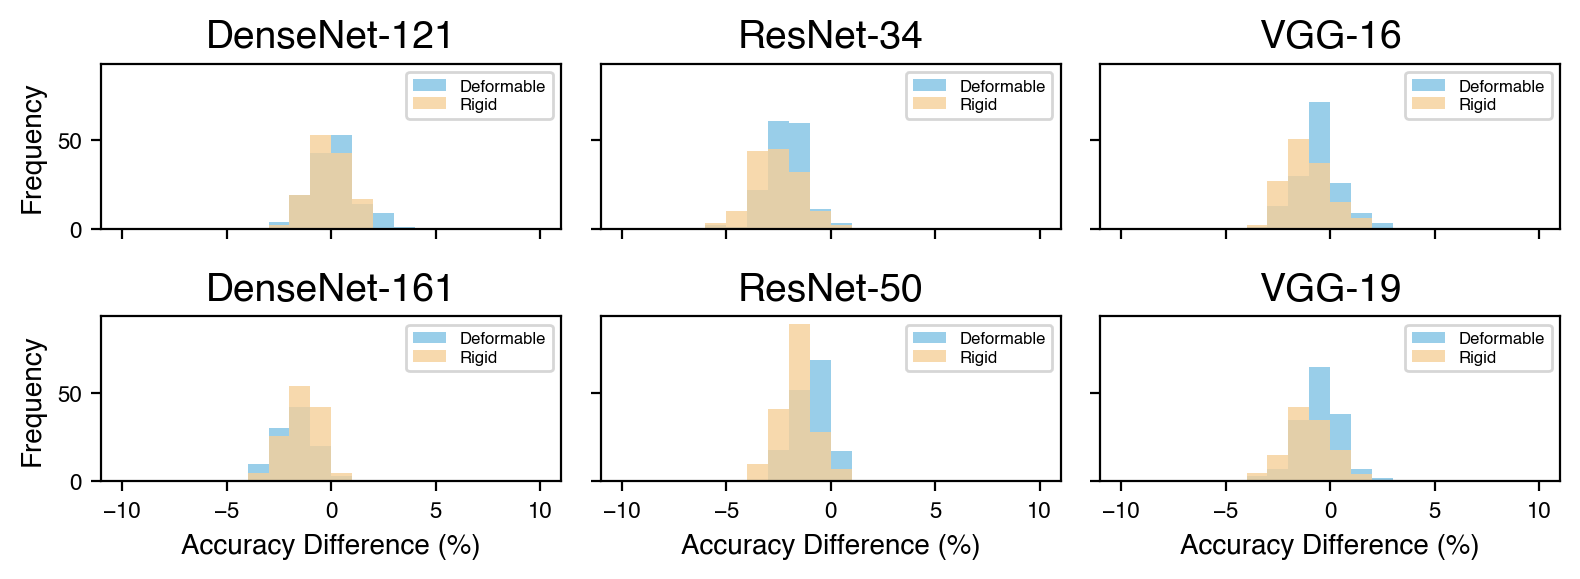

In [370]:
cub200_acc_gen_raw_data = runsXevalXsweeps.loc['cub200', 'accuracy'].reset_index()

cub200_acc_gen_raw_data['acc_generalization_penalty'] = cub200_acc_gen_raw_data['test.accuracy'] - cub200_acc_gen_raw_data['val.accuracy']

# Filter the data for different conditions based on 'arch' and 'distance'
# You will need to replace 'arch_value' and 'distance_value' with actual values from your DataFrame

# Example filters (change 'arch_value' and 'distance_value' to your actual data)
arch_values = cub200_acc_gen_raw_data['arch'].unique()
distance_values = cub200_acc_gen_raw_data['distance'].unique()
backbone_values = cub200_acc_gen_raw_data['backbone'].sort_values().unique()
# Define a figure to plot
fig, axs = plt.subplots(nrows=2, ncols=len(backbone_values)//2, figsize=(8, 3), sharex=True, sharey=True)

# Loop through each combination of arch and distance and plot the histograms

def prototype_type(arch):
    if arch == 'vanilla':
        return 'Rigid'
    if arch == 'deformable':
        return 'Deformable'
    return arch

for k, backbone in enumerate(backbone_values):
    ax = axs[k%2, k//2]

    if k//2 == 0:
        ax.set_ylabel('Frequency')
    if k%2 == 1:
        ax.set_xlabel('Accuracy Difference (%)')

    
    for i, arch in enumerate(arch_values):
        for j, distance in enumerate(distance_values):
            if distance == 'l2':
                continue

            
            subset = cub200_acc_gen_raw_data[(cub200_acc_gen_raw_data['arch'] == arch) & 
                                            (cub200_acc_gen_raw_data['distance'] == distance) & 
                                            (cub200_acc_gen_raw_data['backbone'] == backbone)]
            ax.hist(subset['acc_generalization_penalty']*100, alpha=0.8, label=f'{prototype_type(arch)}', bins=20, range=(-10, 10))

    ax.set_title(stylize(backbone))

    # Add a legend
    ax.legend()

# Show the plot
fig.tight_layout()
plt.show()


In [371]:
fig.savefig('figures/deformable-vs-vanilla-generalization.pdf', backend='pgf')

#### T-Tests on Generalization

##### Cos vs. Euclidean

In [214]:
from scipy import stats

vanilla_all = cub200_acc_gen_raw_data[(cub200_acc_gen_raw_data['arch'] == 'vanilla') & (cub200_acc_gen_raw_data['acc_generalization_penalty'].isna() == False)]

vanilla_l2 = vanilla_all[vanilla_all['distance'] == 'l2']
vanilla_cos = vanilla_all[vanilla_all['distance'] == 'cos']

t_stat, p_value = stats.ttest_ind(vanilla_cos['acc_generalization_penalty'], vanilla_l2['acc_generalization_penalty'], alternative='greater', equal_var=False)

print(
    round(vanilla_cos['acc_generalization_penalty'].mean()*100, 1),
    round(vanilla_l2['acc_generalization_penalty'].mean()*100, 1),
    t_stat,
    p_value,
    len(vanilla_cos) + len(vanilla_l2),
)

-1.4 -1.7 2.943725626315898 0.0017710241669569658 1031


##### Deformable vs. Vanilla

In [215]:
backboned_data =cub200_acc_gen_raw_data[(cub200_acc_gen_raw_data['distance'] == 'cos') & (cub200_acc_gen_raw_data['acc_generalization_penalty'].isna() == False)]

deformable = backboned_data[backboned_data['arch'] == 'deformable']
vanilla = backboned_data[backboned_data['arch'] == 'vanilla']

t_stat, p_value = stats.ttest_ind(deformable['acc_generalization_penalty'], vanilla['acc_generalization_penalty'], alternative='greater', equal_var=False)

print(
    round(deformable['acc_generalization_penalty'].mean()*100, 1),
    round(vanilla['acc_generalization_penalty'].mean()*100, 1),
    t_stat,
    p_value,
    len(deformable['acc_generalization_penalty']) + len(vanilla['acc_generalization_penalty'])
)

-0.9 -1.4 7.036111754093862 1.4225713055507895e-12 1721


### (Excluded) Figure - Generalization on Diagonal

In [142]:
# from matplotlib.colors import Normalize


# fig, axs = plt.subplots(nrows=2, ncols=len(backbone_values)//2, figsize=(8, 3), sharex=True, sharey=True)

# marker = {
#     'vanilla': '.',
#     'deformable': 'x',
# }

# norm = Normalize(vmin=cub200_acc_gen_raw_data['val.prototype_score'].min(), vmax=cub200_acc_gen_raw_data['val.prototype_score'].max())

# cmap = plt.get_cmap('plasma')
# for k, backbone in enumerate(backbone_values):
#     ax = axs[k%2, k//2]
    
#     for i, arch in enumerate(['vanilla']): # enumerate(arch_values):
#         # for j, distance in enumerate(distance_values):
#         #     if arch == 'deformable' and distance == 'l2':
#                 # continue

#             # if arch == 'vanilla' and backbone == 'resnet50':
#             #     ax.text(0.5, 0.5, 'incomplete data', transform=ax.transAxes,
#             #         fontsize=16, color='gray', alpha=0.5,
#             #         ha='center', va='center', rotation=30)

            
#         subset = cub200_acc_gen_raw_data[(cub200_acc_gen_raw_data['backbone'] == backbone)]
#         ax.scatter(subset['val.accuracy'], subset['test.accuracy'], alpha=0.1, label=f'Arch: {arch}, Distance: {distance}, len: {len(subset)}', marker=marker[arch], c=cmap(norm(subset['val.prototype_score'])))

#         slope, intercept = np.polyfit(subset['val.accuracy'], subset['test.accuracy'], 1)
#         y_fit = slope * subset['val.accuracy'] + intercept
#         ax.plot(subset['val.accuracy'], y_fit, color='gray', linestyle='dashed')


#     plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    
#     # Add labels and title
#     ax.xmin=-0.5
#     ax.xmax=0.0
#     ax.set_xlabel('Validation Accuracy')
#     ax.set_ylabel('Test Accuracy')
#     ax.set_title(stylize(backbone))

#     # Add a legend
#     ax.legend()

# # Show the plot
# plt.show()

### Figure - Comparison of ProtoPNet Cosine and L2 Accuracies (`l2_vs_cos`)

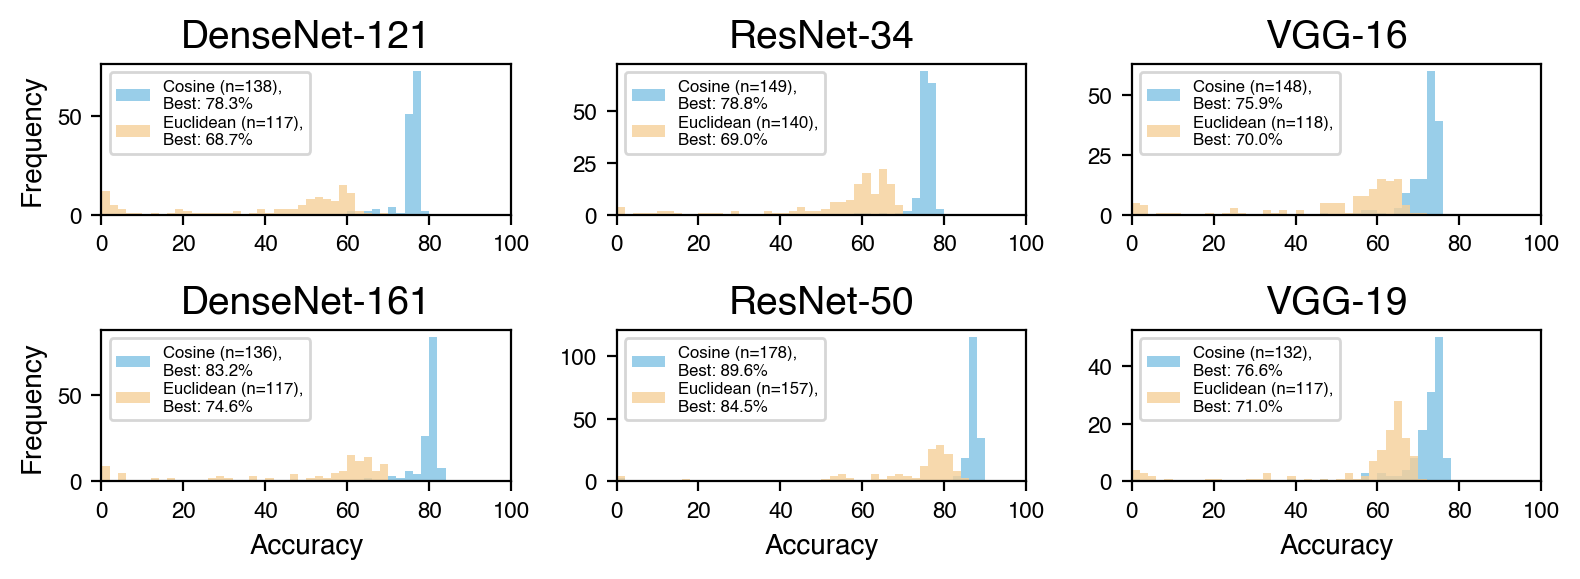

In [372]:
l2_vs_cos_raw = runsXevalXsweeps.loc['cub200', 'accuracy', 'vanilla'].reset_index()

distances = l2_vs_cos_raw['distance'].unique()
backbones = l2_vs_cos_raw['backbone'].unique()

l2_vs_cos_raw['gold_acc_100'] = l2_vs_cos_raw['eval.gold_accuracy@best_step'] * 100
fig, axes = plt.subplots(nrows=2, ncols=len(backbones)//2, figsize=(8, 3), sharex=False, sharey=False)

backbones = l2_vs_cos_raw['backbone'].sort_values().unique()
for j, backbone in enumerate(backbones):
    ax = axes[j%2, j//2]
    subset = l2_vs_cos_raw[(l2_vs_cos_raw['backbone'] == backbone)]
    # We can use seaborn's hue option for coloring by 'distance'
    for selection, subset in [
        ('cos', subset[subset['distance'] == 'cos']),
        ('l2', subset[subset['distance'] == 'l2'])
    ]:
        ax.hist(data=subset, x='gold_acc_100', alpha=0.8, bins=[i for i in range(0, 100, 2)],
                label=f'{stylize(selection)} (n={len(subset)}),\nBest: {round(subset["eval.gold_accuracy@best_step"].max()*100, 1)}%')
    ax.set_title(f'{stylize(backbone)}')
    ax.set_xlim(0.0, 100)
    if j//2 == 0:
        ax.set_ylabel('Frequency')
    if j%2 == 1:
        ax.set_xlabel('Accuracy')
    ax.legend(loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

In [373]:
fig.savefig('figures/l2_vs_cos.pdf', backend='pgf')

### Figure - Learning Comparison of Deformable and Vanilla

In [376]:
cycler = matplotlib.cycler(color=['80c2e4', 'f6d099', '85d992', 'f5f597'])
cycler

cycler('color', ['#80c2e4', '#f6d099', '#85d992', '#f5f597'])

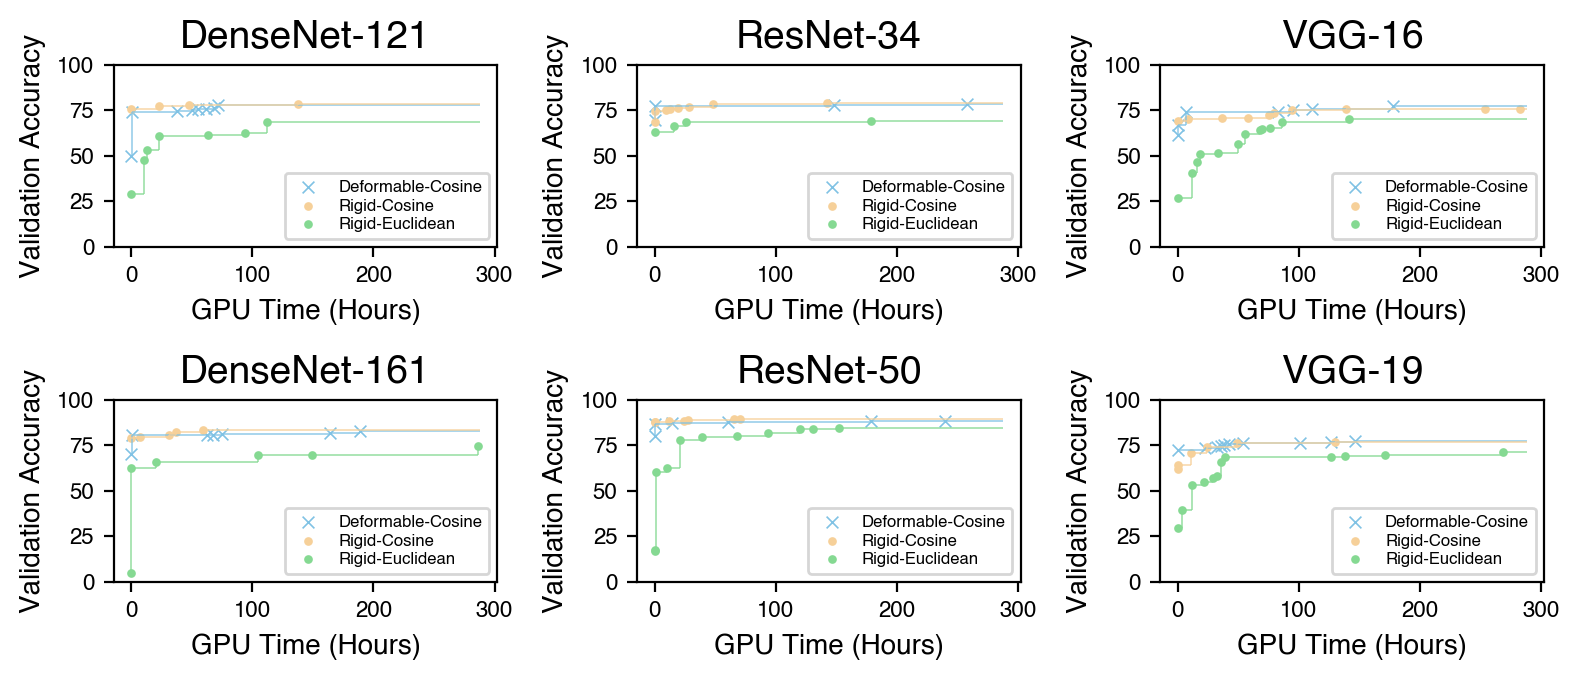

In [377]:
runsXevalXsweeps_cub200_acc = runsXevalXsweeps.loc['cub200', 'accuracy']
backbones = runsXevalXsweeps_cub200_acc.index.get_level_values('backbone').sort_values().unique()
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 3.5), sharex=False, sharey=False)

# TODO - replace with multiple backbones
for i, backbone in enumerate(backbones):
    ax = axs[i%2, i//2]

    for j, arch in enumerate(runsXevalXsweeps_cub200_acc.index.get_level_values('arch').unique()):
        for k, distance in enumerate(runsXevalXsweeps_cub200_acc.index.get_level_values('distance').unique()):
            if distance == 'l2' and arch == 'deformable':
                continue

            color = list(cycler)[j + k]['color']

            subset_acc = runsXevalXsweeps_cub200_acc.loc[(arch, distance, backbone)].copy()
            # subset_acc = runsXevalXsweeps[(runsXevalXsweeps['backbone'] == backbone) & (runsXevalXsweeps['arch'] == arch) & (runsXevalXsweeps['distance'] == distance) & (runsXevalXsweeps['objective'] == 'accuracy')].copy()

            if len(subset_acc) == 0:
                #FIXME - shouldn't happen with l2 data
                continue

            subset_acc['rel_start_time_hrs'] = (subset_acc['start_time'] - subset_acc['start_time'].min())/60/60*4
            # subset_acc['timestamp_ts'] = pd.to_datetime(subset_acc['timestamp'])
            subset_acc = subset_acc.sort_values('rel_start_time_hrs').sort_values('eval.gold_accuracy@best_step', ascending=False).drop_duplicates('rel_start_time_hrs', keep='first').sort_values('rel_start_time_hrs')
            subset_acc['cummax_val.accuracy'] = (subset_acc['eval.gold_accuracy@best_step'] * 100).cummax()

            # Determine where the changes in maximum occur
            subset_acc['shifted'] = subset_acc['cummax_val.accuracy'].shift(1)
            subset_acc['change_point'] = subset_acc['cummax_val.accuracy'] != subset_acc['shifted']

            # Prepare plotting data
            plot_data = subset_acc[subset_acc['change_point']]

            for i in range(len(plot_data)):
                if i == 0:
                    continue
                previous = plot_data.iloc[i-1]
                current = plot_data.iloc[i]
                # Horizontal line from previous to current
                ax.hlines(y=previous['cummax_val.accuracy'], xmin=previous['rel_start_time_hrs'], xmax=current['rel_start_time_hrs'], alpha=0.8, color=color)
                # Vertical line from previous max to current max
                ax.vlines(x=current['rel_start_time_hrs'], ymin=previous['cummax_val.accuracy'], ymax=current['cummax_val.accuracy'], alpha=0.8, color=color)

            ax.hlines(y=current['cummax_val.accuracy'], xmin=current['rel_start_time_hrs'], xmax=72*4, alpha=0.8, color=color)

            ax.scatter(plot_data['rel_start_time_hrs'], plot_data['cummax_val.accuracy'], label=f'{prototype_type(arch)}-{stylize(distance)}', marker=marker[arch], s=18, alpha=1.0, color=color)

            ax.legend(loc='lower right')
            ax.set_title(f'{stylize(backbone)}')
            ax.set_ylim(0, 100)
    ax.set_ylim(0.0, 100)

    ax.set_xlabel('GPU Time (Hours)')
    ax.set_ylabel('Validation Accuracy')


fig.tight_layout()
plt.show()

In [378]:
fig.savefig('figures/acc_vs_time.pdf', backend='pgf')

## Joint Accuracy Prototype Quality Scores

### Table - `acc_proto_score`s on CUB-200 (`cub200-interp`)

In [258]:
runsXsweeps_aps =  runsXevalXsweeps.loc['cub200', 'accuracy', slice(None), 'cos']

all_targets = ['test.acc_proto_score', 'test.accuracy', 'test.prototype_score']

cub200_interp_raw_data = runsXsweeps_aps[['sweep_id'] + all_targets].copy()

cub200_interp_raw_data.sort_index()

sweep_id  test.acc_proto_score  test.accuracy  \
arch       backbone                                                     
deformable densenet121  oexnj6n3              0.335331       0.758371   
           densenet121  oexnj6n3              0.345396       0.744909   
           densenet121  oexnj6n3              0.343050       0.757163   
           densenet121  oexnj6n3              0.281856       0.743528   
           densenet121  oexnj6n3              0.345191       0.749051   
...                          ...                   ...            ...   
vanilla    vgg19        ahrdy5hq                   NaN            NaN   
           vgg19        ahrdy5hq                   NaN            NaN   
           vgg19        ahrdy5hq                   NaN            NaN   
           vgg19        ahrdy5hq                   NaN            NaN   
           vgg19        ahrdy5hq                   NaN            NaN   

                        test.prototype_score  
arch       backbone                           
deformable densenet121              0.442172  
           densenet121              0.463675  
           densenet121              0.453073  
           densenet121              0.379080  
           densenet121              0.460838  
...                                      ...  
vanilla    vgg19                         NaN  
           vgg19                         NaN  
           vgg19                         NaN  
           vgg19                         NaN  
           vgg19                         NaN  

[1837 rows x 4 columns]

In [273]:
def bests_raw(df):
    df = df.rename(columns={'metric': 'sweep.target_metric'})
    key_cols = ['dataset', 'arch', 'distance', 'backbone', 'schedule_adjust', 'sweep.target_metric']
    bests_raw = pd.DataFrame()

    for measure in ['accuracy', 'acc_proto_score']:
        for selection in ['val', 'test']:
            grouping = df.groupby(key_cols, dropna=False)
            max_rows = grouping[f'{selection}.{measure}'].idxmax()
            these_bests = df.loc[max_rows, key_cols + ['run_id', f'{selection}.{measure}']]
            these_bests.rename(columns={f'{selection}.{measure}': 'best_target'}, inplace=True)
            these_bests['selection.split'] = selection
            these_bests['selection.metric'] = measure
            bests_raw = pd.concat([bests_raw, these_bests])

    return bests_raw

all_targets = ['test.acc_proto_score', 'test.accuracy', 'test.prototype_score', 'test.prototype_consistency', 'test.prototype_stability', 'val.acc_proto_score', 'val.accuracy', 'val.prototype_score', 'val.prototype_consistency', 'val.prototype_stability']

cub200_bests_raw = bests_raw(runsXevalXsweeps.reset_index()).merge(eval[['run_id'] + all_targets], on='run_id')
cub200_bests_raw

dataset        arch distance     backbone schedule_adjust  \
0    cub200  deformable      cos  densenet121              1x   
1    cub200  deformable      cos  densenet161              1x   
2    cub200  deformable      cos  densenet161              1x   
3    cub200  deformable      cos     resnet34              1x   
4    cub200  deformable      cos     resnet50              1x   
..      ...         ...      ...          ...             ...   
115  cub200     vanilla      cos     resnet50              1x   
116  cub200     vanilla      cos        vgg16              1x   
117  cub200     vanilla       l2     resnet50              1x   
118  cub200     vanilla       l2        vgg19              1x   
119    dogs  deformable      cos        vgg19              1x   

    sweep.target_metric    run_id  best_target selection.split  \
0              accuracy  3daz8cuv     0.781145             val   
1       acc_proto_score  fgk25hlj     0.818182             val   
2              accuracy  xldqums4     0.828283             val   
3              accuracy  xn5mhfu8     0.786195             val   
4       acc_proto_score  oqy0ebqp     0.872054             val   
..                  ...       ...          ...             ...   
115            accuracy  5wtd3n7h     0.664993            test   
116            accuracy  gndl8vlz     0.523818            test   
117            accuracy  ejawjngy     0.312950            test   
118            accuracy  lzg9cfnj     0.331013            test   
119            accuracy  e93lbpji     0.351779            test   

    selection.metric  test.acc_proto_score  test.accuracy  \
0           accuracy              0.296773       0.753711   
1           accuracy              0.340065       0.795305   
2           accuracy              0.316859       0.791163   
3           accuracy              0.242645       0.735589   
4           accuracy              0.421065       0.848464   
..               ...                   ...            ...   
115  acc_proto_score              0.664993       0.850880   
116  acc_proto_score              0.523818       0.692268   
117  acc_proto_score              0.312950       0.683811   
118  acc_proto_score              0.331013       0.686055   
119  acc_proto_score              0.351779       0.711888   

     test.prototype_score  test.prototype_consistency  \
0                0.393749                    0.009545   
1                0.427590                    0.000000   
2                0.400498                    0.005000   
3                0.329865                    0.000357   
4                0.496267                    0.232857   
..                    ...                         ...   
115              0.781536                    0.990000   
116              0.756670                    1.000000   
117              0.457656                    0.835000   
118              0.482488                    0.927813   
119              0.494150                    0.000000   

     test.prototype_stability  val.acc_proto_score  val.accuracy  \
0                    0.823392             0.308625      0.781145   
1                    0.967570             0.346751      0.818182   
2                    0.872407             0.331784      0.828283   
3                    0.851527             0.266972      0.786195   
4                    0.565907             0.585878      0.872054   
..                        ...                  ...           ...   
115                  0.605542             0.671320      0.868687   
116                  0.665779             0.522954      0.686869   
117                  0.324520             0.340947      0.696970   
118                  0.423079             0.333457      0.680135   
119                  1.000000             0.352905      0.714167   

     val.prototype_score  val.prototype_consistency  val.prototype_stability  
0               0.395094                   0.026364                 0.810606  
1               0.423807             

In [276]:
cub200_bests_1x = cub200_bests_raw.loc[
    (cub200_bests_raw['dataset'] == 'cub200') &
    (cub200_bests_raw['schedule_adjust'] == '1x') & 
    (cub200_bests_raw['backbone'].isin(['resnet50', 'vgg19', 'densenet161'])) &
    (cub200_bests_raw['distance'] == 'cos')]
cub200_bests_hierarchy = cub200_bests_1x.pivot(index=['arch', 'selection.split', 'sweep.target_metric', 'selection.metric'], columns=['backbone'], values=['run_id', 'test.accuracy', 'test.acc_proto_score', 'test.prototype_score', 'test.prototype_consistency']) \
    .swaplevel(axis=1) \
    .sort_index(axis=1)

cub200_best_on_obj = cub200_bests_hierarchy[
    (cub200_bests_hierarchy.index.get_level_values('sweep.target_metric') == cub200_bests_hierarchy.index.get_level_values('selection.metric'))]
cub200_best_on_obj

backbone                                                        densenet161  \
                                                                     run_id   
arch       selection.split sweep.target_metric selection.metric               
deformable test            acc_proto_score     acc_proto_score     0zdoi4y4   
                           accuracy            accuracy            zj3kc1j3   
           val             acc_proto_score     acc_proto_score     drq371da   
                           accuracy            accuracy            xldqums4   
vanilla    test            acc_proto_score     acc_proto_score     h45q9x5t   
                           accuracy            accuracy            n84bjof8   
           val             acc_proto_score     acc_proto_score     h45q9x5t   
                           accuracy            accuracy            daepzcx6   

backbone                                                                              \
                                                                test.acc_proto_score   
arch       selection.split sweep.target_metric selection.metric                        
deformable test            acc_proto_score     acc_proto_score               0.43791   
                           accuracy            accuracy                     0.338096   
           val             acc_proto_score     acc_proto_score              0.350623   
                           accuracy            accuracy                     0.316859   
vanilla    test            acc_proto_score     acc_proto_score              0.666653   
                           accuracy            accuracy                     0.452923   
           val             acc_proto_score     acc_proto_score              0.666653   
                           accuracy            accuracy                     0.483986   

backbone                                                                       \
                                                                test.accuracy   
arch       selection.split sweep.target_metric selection.metric                 
deformable test            acc_proto_score     acc_proto_score       0.747843   
                           accuracy            accuracy              0.799448   
           val             acc_proto_score     acc_proto_score       0.764239   
                           accuracy            accuracy              0.791163   
vanilla    test            acc_proto_score     acc_proto_score       0.779082   
                           accuracy            accuracy              0.808768   
           val             acc_proto_score     acc_proto_score       0.779082   
                           accuracy            accuracy              0.807042   

backbone                                                                                    \
                                                                test.prototype_consistency   
arch       selection.split sweep.target_metric selection.metric                              
deformable test            acc_proto_score     acc_proto_score                         0.0   
                           accuracy            accuracy                                0.0   
           val             acc_proto_score     acc_proto_score                        0.16   
                           accuracy            accuracy                              0.005   
vanilla    test            acc_proto_score     acc_proto_score                    0.998333   
                           accuracy            accuracy                           0.778571   
           val             acc_proto_score     acc_proto_score                    0.998333   
                           accuracy            accuracy                            0.84375   

backbone                                                                              \
                                                                test.prototype_score   
arch       selection.split sweep.target_metric selection.m

In [277]:
def backbone_cols(cols, backbones=['resnet50', 'vgg19', 'densenet161']):
    references = []
    if type(cols) == str:
        cols = [cols]
    for backbone in backbones:
        for col in cols:
            references.append((backbone, col))
    return references

In [278]:
cub200_best_on_test_acc = cub200_bests_hierarchy[
    (cub200_bests_hierarchy.index.get_level_values('selection.metric') == 'accuracy')]

cub200_joint_table = cub200_best_on_test_acc[backbone_cols(['test.accuracy', 'test.prototype_score'])] \
    .swaplevel(0, 1, axis=0) \
    .loc['val'] \
    .droplevel('selection.metric', axis=0) \
    .rename(stylize, axis=1) \
    .rename(stylize) \
    .sort_index(axis=0, ascending=False) * 100

cub200_joint_table.index.rename(['sweep.target_metric', 'arch'], inplace=True)
    # .droplevel('selection.split', axis=0) \
    
cub200_joint_table

backbone                  ResNet-50                VGG-19             \
                                Acc         PS        Acc         PS   
sweep.target_metric arch                                               
ProtoPNet           Acc   86.399722   67.59901  74.128407  50.641227   
                    A-PS  86.244392  81.367159  73.541594    63.5656   
Deformable          Acc   85.502243  39.618716  73.990333   17.94337   
                    A-PS  84.846395   49.62669  75.267518  33.757102   

backbone                 DenseNet-161             
                                  Acc         PS  
sweep.target_metric arch                          
ProtoPNet           Acc     80.704176  59.970427  
                    A-PS    79.237139  73.613924  
Deformable          Acc     79.116327  40.049773  
                    A-PS    79.530549  42.758983

In [309]:
# cub200_joint_table.to_latex('tables/cub200-interp.tex', formatters=[single_digit_formatter]*cub200_joint_table.shape[1])

### Table - joint for test

In [281]:
cub200_joint_table_test = cub200_best_on_test_acc[backbone_cols(['test.accuracy', 'test.prototype_score'])] \
    .swaplevel(0, 1, axis=0) \
    .droplevel('selection.metric', axis=0) \
    .rename(stylize, axis=1) \
    .rename(stylize) \
    .sort_index(axis=0, ascending=False) * 100

cub200_joint_table_test

backbone                                        ResNet-50             \
                                                      Acc         PS   
selection.split arch       sweep.target_metric                         
val             ProtoPNet  Acc                  86.399722   67.59901   
                           A-PS                 86.244392  81.367159   
                Deformable Acc                  85.502243  39.618716   
                           A-PS                 84.846395   49.62669   
test            ProtoPNet  Acc                   86.96928  61.127335   
                           A-PS                 87.021059  72.251385   
                Deformable Acc                  86.762166  38.190579   
                           A-PS                  85.38143  33.481643   

backbone                                           VGG-19             \
                                                      Acc         PS   
selection.split arch       sweep.target_metric                         
val             ProtoPNet  Acc                  74.128407  50.641227   
                           A-PS                 73.541594    63.5656   
                Deformable Acc                  73.990333   17.94337   
                           A-PS                 75.267518  33.757102   
test            ProtoPNet  Acc                  74.887812  56.898493   
                           A-PS                 73.817742   61.22939   
                Deformable Acc                  75.888848  38.677305   
                           A-PS                 75.267518  33.757102   

backbone                                       DenseNet-161             
                                                        Acc         PS  
selection.split arch       sweep.target_metric                          
val             ProtoPNet  Acc                    80.704176  59.970427  
                           A-PS                   79.237139  73.613924  
                Deformable Acc                    79.116327  40.049773  
                           A-PS                   79.530549  42.758983  
test            ProtoPNet  Acc                    80.876768  56.001568  
                           A-PS                   80.203658  72.257775  
                Deformable Acc                    79.944772   42.29123  
                           A-PS                   79.910254  46.227932

In [282]:
# cub200_joint_table_test.to_latex('tables/cub200-interp-test.tex', formatters=[single_digit_formatter]*cub200_joint_table_test.shape[1])

### Table - joint on acc_proto_score

In [280]:
cub200_best_on_test_aps = cub200_bests_hierarchy[
    (cub200_bests_hierarchy.index.get_level_values('selection.metric') == 'acc_proto_score')]

cub200_joint_table_aps = cub200_best_on_test_acc[backbone_cols(['test.accuracy', 'test.prototype_score'])] \
    .droplevel('selection.metric', axis=0) \
    .swaplevel(0, 1, axis=0) \
    .rename(stylize, axis=1) \
    .rename(stylize) \
    .sort_index(axis=0, ascending=False) * 100

cub200_joint_table_aps.index.rename({'sweep.target_metric': 'Obj'}, inplace=True)
cub200_joint_table_aps.index.rename({'selection.split': 'Selection'}, inplace=True)
    
cub200_joint_table_aps

backbone                   ResNet-50                VGG-19             \
                                 Acc         PS        Acc         PS   
Selection arch       Obj                                                
val       ProtoPNet  Acc   86.399722   67.59901  74.128407  50.641227   
                     A-PS  86.244392  81.367159  73.541594    63.5656   
          Deformable Acc   85.502243  39.618716  73.990333   17.94337   
                     A-PS  84.846395   49.62669  75.267518  33.757102   
test      ProtoPNet  Acc    86.96928  61.127335  74.887812  56.898493   
                     A-PS  87.021059  72.251385  73.817742   61.22939   
          Deformable Acc   86.762166  38.190579  75.888848  38.677305   
                     A-PS   85.38143  33.481643  75.267518  33.757102   

backbone                  DenseNet-161             
                                   Acc         PS  
Selection arch       Obj                           
val       ProtoPNet  Acc     80.704176  59.970427  
                     A-PS    79.237139  73.613924  
          Deformable Acc     79.116327  40.049773  
                     A-PS    79.530549  42.758983  
test      ProtoPNet  Acc     80.876768  56.001568  
                     A-PS    80.203658  72.257775  
          Deformable Acc     79.944772   42.29123  
                     A-PS    79.910254  46.227932

In [313]:
# cub200_joint_table_aps.to_latex('tables/cub200-interp-aps.tex', formatters=[single_digit_formatter]*cub200_joint_table_aps.shape[1])

### Figure - Training Progression of Accuracy and `acc_proto_score` (`interp-gpu-hour-payout`)

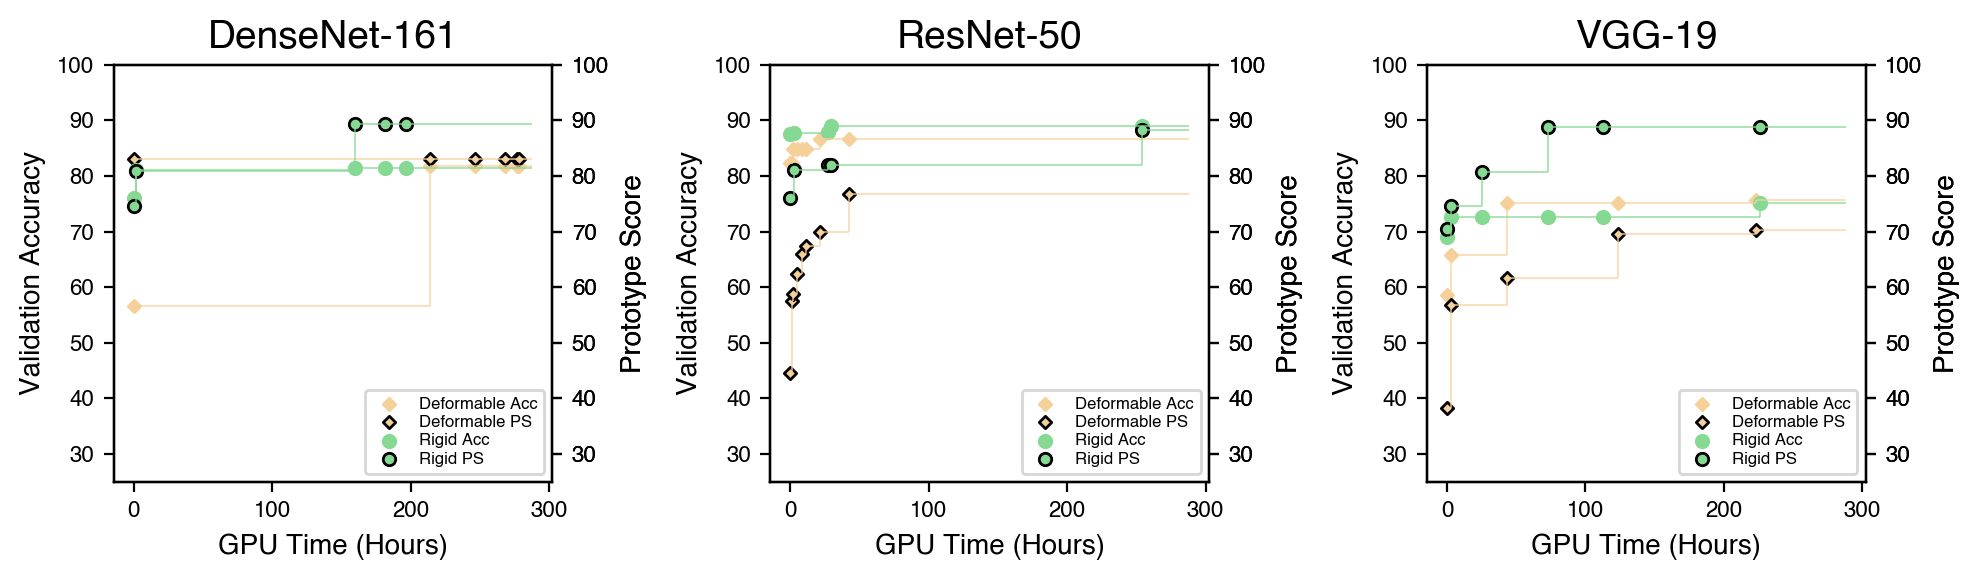

In [403]:
import matplotlib.path as mpath
circle_for_cut = mpath.Path.circle(radius=.8)
circle = mpath.Path.circle(radius=1)
hex = mpath.Path.unit_regular_polygon(4)
hex_for_cut = mpath.Path.unit_regular_polygon(4)
# Reverse the star's vertices for the cutout effect and ensure the path starts with MOVETO

circle_for_cut_reversed = circle_for_cut.vertices[::-1]
circle_for_cut_codes_reversed = circle_for_cut.codes.copy()
circle_for_cut_codes_reversed[0] = mpath.Path.MOVETO  # Start a new subpath for the star

hex_for_cut_reversed = hex_for_cut.vertices[::-1] * .9
hex_for_cut_codes_reversed = hex_for_cut.codes.copy()
hex_for_cut_codes_reversed[0] = mpath.Path.MOVETO  # Start a new subpath for the star

# Concatenate the circle with the reversed star for the cutout
cut_circle = mpath.Path(
    vertices=np.concatenate([circle.vertices, circle_for_cut_reversed]),
    codes=np.concatenate([circle.codes, circle_for_cut_codes_reversed]))

cut_hex = mpath.Path(
    vertices=np.concatenate([hex.vertices, hex_for_cut_reversed]),
    codes=np.concatenate([hex.codes, hex_for_cut_codes_reversed]))


joint_markers = {
    'vanilla': {
        'accuracy': circle,
        'prototype_score': circle,
    },
    'deformable': {
        'accuracy': hex,
        'prototype_score': hex,
    }
}

backbone_dist_colors = {
    'vanilla': {
        'cos': 'blue',
        'l2': 'green',
    },
    'deformable': {'cos': 'orange'},
}

backbones = ['densenet161', 'resnet50', 'vgg19']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharex=False, sharey=False)

aps_subset = runsXevalXsweeps.loc['cub200', 'acc_proto_score']

# TODO - replace with multiple backbones
for i, backbone in enumerate(backbones):
    this_ax = axs[i]

    for j, arch in enumerate(aps_subset.index.get_level_values('arch').unique()):


        color = list(cycler)[j + k]['color']

        subset_acc = aps_subset.loc[arch, 'cos', backbone].copy()
        subset_acc = subset_acc[subset_acc['val.acc_proto_score'].isna() == False]
        
        subset_acc['rel_start_time_hrs'] = (subset_acc['start_time'] - subset_acc['start_time'].min())/60/60*4
        # subset_acc['timestamp_ts'] = pd.to_datetime(subset_acc['timestamp'])
        subset_acc = subset_acc.sort_values('rel_start_time_hrs').sort_values('val.acc_proto_score', ascending=False).drop_duplicates('rel_start_time_hrs', keep='first').sort_values('rel_start_time_hrs')
        subset_acc['cummax_val.accuracy'] = (subset_acc['val.accuracy'].cummax() * 100)
        subset_acc['cummax_val.prototype_score'] = (subset_acc['val.prototype_score'].cummax() * 100)
        subset_acc['cummax_val.acc_proto_score'] = (subset_acc['val.acc_proto_score'].cummax() * 100)

        # Determine where the changes in maximum occur
        subset_acc['shifted'] = subset_acc[f'cummax_val.acc_proto_score'].shift(1)
        subset_acc['change_point'] = subset_acc[f'cummax_val.acc_proto_score'] != subset_acc['shifted']
        # Prepare plotting data
        plot_data = subset_acc[subset_acc['change_point']]

        these_axs = [this_ax, this_ax.twinx()]

        for ax, metric in [(these_axs[0], 'accuracy'), (these_axs[0], 'prototype_score')]:

            edgecolor = None if metric == 'accuracy' else 'black'
            linestyle = 'solid' #if metric == 'accuracy' else 'dotted'

            for i in range(1, len(plot_data)):
                previous = plot_data.iloc[i-1]
                current = plot_data.iloc[i]

                # Horizontal line from previous to current
                ax.hlines(y=previous[f'cummax_val.{metric}'], xmin=previous['rel_start_time_hrs'], xmax=current['rel_start_time_hrs'], color=color, linestyle=linestyle, alpha=.8)
                # Vertical line from previous max to current max
                ax.vlines(x=current['rel_start_time_hrs'], ymin=previous[f'cummax_val.{metric}'], ymax=current[f'cummax_val.{metric}'], color=color, linestyle=linestyle, alpha=.8)

            ax.hlines(y=current[f'cummax_val.{metric}'], xmin=current['rel_start_time_hrs'], xmax=72*4, color=color, linestyle=linestyle, alpha=0.8)

            ax.scatter(plot_data['rel_start_time_hrs'], plot_data[f'cummax_val.{metric}'], label=f'{prototype_type(arch)} {stylize(metric)}', facecolor=color, edgecolor=edgecolor, marker=joint_markers[arch][metric], s=20)
            
        these_axs[0].set_ylim(25, 100)
        these_axs[1].set_ylim(25, 100)
        these_axs[0].set_title(f'{stylize(backbone)}')
        these_axs[0].set_ylabel('Validation Accuracy')
        these_axs[1].set_ylabel('Prototype Score')
        these_axs[0].legend(loc='lower right')

        these_axs[0].set_xlabel('GPU Time (Hours)')


fig.tight_layout()
plt.show()

In [404]:
fig.savefig('figures/interp-gpu-hour-payout.pdf', backend='pgf')

### Figure - Correlation of accuracy and `acc_proto_score` (`acc-interp-corrlation`)

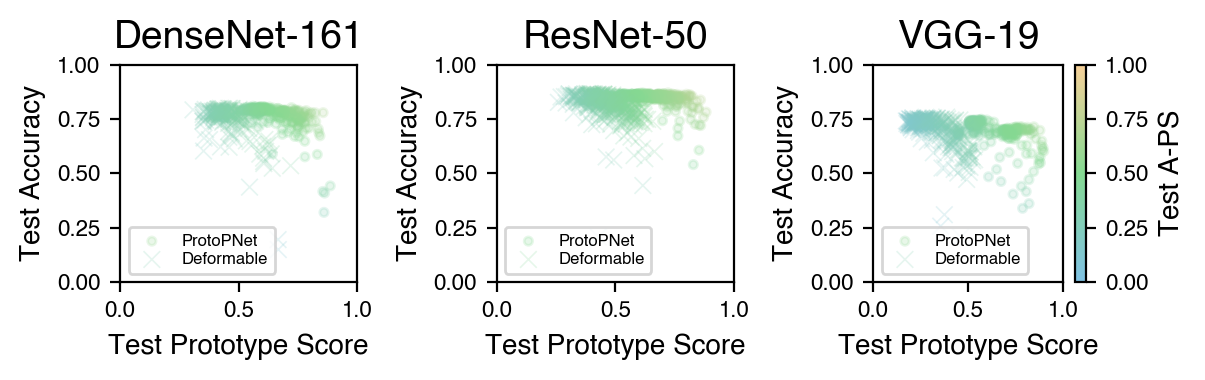

In [423]:
from matplotlib.colors import LinearSegmentedColormap


backbones = ['densenet161', 'resnet50', 'vgg19']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 2))

marker = {
    'deformable': 'x',
    'vanilla': '.',
}

norm = Normalize(vmin=0, vmax=1)
#'f6d099',
cmap = LinearSegmentedColormap.from_list("mycmap", ['#80c2e4',  '#85d992', '#f6d099'])


for i, backbone in enumerate(backbones):
    ax = axs[i]
    subset = runsXevalXsweeps.loc['cub200', slice(None), slice(None), slice(None), backbone].copy()

    # normed_score = norm()
    for arch in ['vanilla', 'deformable']:
        arch_subset = subset.loc[slice(None), arch, 'cos']
        ax.scatter(arch_subset['test.prototype_score'], arch_subset['test.accuracy'], cmap=cmap, marker=marker[arch], alpha=.2, c=arch_subset['test.acc_proto_score'], norm=norm, label=stylize(arch))

    if i == 2:
        plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Test A-PS')
    ax.legend(loc='lower left')
    ax.set_title(f'{stylize(backbone)}')
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel('Test Prototype Score')
    ax.set_ylabel('Test Accuracy')

fig.tight_layout()
plt.show()

In [424]:
fig.savefig('figures/acc-interp-correlation.pdf', backend='pgf')

### Figure - Generalization Penalty By Acc Prototype Score

In [337]:
# from matplotlib.colors import Normalize


# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 1.5), sharex=True, sharey=True)

# marker = {
#     'vanilla': '.',
#     'deformable': 'x',
# }

# norm = Normalize(vmin=cub200_acc_gen_raw_data['val.prototype_score'].min(), vmax=cub200_acc_gen_raw_data['val.prototype_score'].max())

# cmap = plt.get_cmap('plasma')
# for k, backbone in enumerate(['densenet161', 'resnet50', 'vgg19']):
#     ax = axs[k]
    
#     for i, arch in enumerate(['vanilla', 'deformable']): # enumerate(arch_values):

#         subset = cub200_acc_gen_raw_data[(cub200_acc_gen_raw_data['backbone'] == backbone)]
#         ax.scatter(subset['val.accuracy'], subset['test.accuracy'], alpha=0.1, label=f'Arch: {arch}, Distance: {distance}, len: {len(subset)}', marker=marker[arch], c=cmap(norm(subset['val.prototype_score'])))

#         slope, intercept = np.polyfit(subset['val.accuracy'], subset['test.accuracy'], 1)
#         y_fit = slope * subset['val.accuracy'] + intercept
#         ax.plot(subset['val.accuracy'], y_fit, color='gray', linestyle='dashed')


#     plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    
#     # Add labels and title
#     ax.xmin=-0.5
#     ax.xmax=0.0
#     ax.set_xlabel('Validation Accuracy')
#     ax.set_ylabel('Test Accuracy')
#     ax.set_title(stylize(backbone))

#     # Add a legend
#     ax.legend()

# # Show the plot
# plt.show()

## Appendices

### Table - Accuracy on Stanford Dogs (`dogs-acc`)

In [578]:
runsXevalXsweeps_acc_dogs = runsXevalXsweeps.loc['dogs', 'accuracy']
runsXevalXsweeps_acc_dogs

run_id  \
arch       distance backbone                
deformable cos      densenet161  uv5x7rzf   
                    densenet161  2mgvfsci   
                    densenet161  cdc05hr7   
                    densenet161  lr8torg5   
                    densenet161  78b30e3l   
...                                   ...   
vanilla    cos      vgg19        spe62uss   
                    vgg19        r4jkjbuy   
                    vgg19        mnebcjg7   
                    vgg19        rx89i6y4   
                    vgg19        ckjitepd   

                                                                          name_run  \
arch       distance backbone                                                         
deformable cos      densenet161  cc--5.8E-01_im-False_jlss-9_kft-6_lc-2.6E-05_l...   
                    densenet161  cc--7.9E-01_im-False_jlss-7_kft-10_lc-1.6E-04_...   
                    densenet161  cc--6.9E-01_im-False_jlss-8_kft-4_lc-9.1E-05_l...   
                    densenet161  cc--5.8E-01_im-False_jlss-9_kft-7_lc-1.2E-04_l...   
                    densenet161  cc-3.0E-01_im-False_jlss-9_kft-4_lc-2.5E-05_ld...   
...                                                                            ...   
vanilla    cos      vgg19        cc--4.6E-01_im-False_jlss-9_lc-8.0E-04_ldme-1_...   
                    vgg19        cc--2.6E+00_im-False_jlss-2_lc-2.6E-04_ldme-0_...   
                    vgg19        cc--8.7E-01_im-False_jlss-2_lc-1.9E-05_ldme--2...   
                    vgg19        cc--6.7E-01_im-False_jlss-6_lc-8.0E-04_ldme-1_...   
                    vgg19        cc--6.8E-01_im-False_jlss-3_lc-1.7E-04_ldme--2...   

                                 sweep_id            timestamp  \
arch       distance backbone                                     
deformable cos      densenet161  o12zm01u  2024-05-21 08:24:15   
                    densenet161  o12zm01u  2024-05-21 07:30:06   
                    densenet161  o12zm01u  2024-05-21 06:29:55   
                    densenet161  o12zm01u  2024-05-21 05:44:05   
                    densenet161  o12zm01u  2024-05-21 08:32:42   
...                                   ...                  ...   
vanilla    cos      vgg19        1teehly9  2024-05-17 00:17:22   
                    vgg19        1teehly9  2024-05-17 00:36:44   
                    vgg19        1teehly9  2024-05-16 22:13:43   
                    vgg19        1teehly9                  NaN   
                    vgg19        1teehly9  2024-05-17 00:27:14   

                                                                         save_path  \
arch       distance backbone                                                         
deformable cos      densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/o12...   
                    densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/o12...   
                    densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/o12...   
                    densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/o12...   
                    densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/o12...   
...                                                                            ...   
vanilla    cos      vgg19        /usr/xtmp/ppnxt/neurips2024/live/artifacts/1te...   
                    vgg19        /usr/xtmp/ppnxt/neurips2024/live/artifacts/1te...   
                    vgg19        /usr/xtmp/ppnxt/neurips2024/live/artifacts/1te...   
                    vgg19                                                      NaN   
                    vgg19        /usr/xtmp/ppnxt/neurips2024/live/artifacts/1te...   

                                                                           url_run  \
arch       distance backbone                                                         
deformable cos      densenet161  https://wandb.ai/protopnext/neurips-experiment...   
                    densenet161  https://wandb.ai/protopnext/neurips-experiment...   
        

In [474]:
runsXevalXsweeps_acc_dogs.shape

(270, 80)

In [488]:
runtimes = pd.read_csv('data/runs_wandb_runtime.csv')
runsXevalXsweeps_acc_dogs = runsXevalXsweeps_acc_dogs.reset_index().merge(runtimes, on='run_id').set_index(['arch', 'distance', 'backbone', 'run_id'])
runsXevalXsweeps_acc_dogs.head(3).pipe(display)
runsXevalXsweeps_acc_dogs.shape

run_id  \
arch       distance backbone                
deformable cos      densenet161  uv5x7rzf   
                    densenet161  2mgvfsci   
                    densenet161  cdc05hr7   

                                                                          name_run  \
arch       distance backbone                                                         
deformable cos      densenet161  cc--5.8E-01_im-False_jlss-9_kft-6_lc-2.6E-05_l...   
                    densenet161  cc--7.9E-01_im-False_jlss-7_kft-10_lc-1.6E-04_...   
                    densenet161  cc--6.9E-01_im-False_jlss-8_kft-4_lc-9.1E-05_l...   

                                 sweep_id            timestamp  \
arch       distance backbone                                     
deformable cos      densenet161  o12zm01u  2024-05-21 08:24:15   
                    densenet161  o12zm01u  2024-05-21 07:30:06   
                    densenet161  o12zm01u  2024-05-21 06:29:55   

                                                                         save_path  \
arch       distance backbone                                                         
deformable cos      densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/o12...   
                    densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/o12...   
                    densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/o12...   

                                                                           url_run  \
arch       distance backbone                                                         
deformable cos      densenet161  https://wandb.ai/protopnext/neurips-experiment...   
                    densenet161  https://wandb.ai/protopnext/neurips-experiment...   
                    densenet161  https://wandb.ai/protopnext/neurips-experiment...   

                                objective  objective_value  multiplier  \
arch       distance backbone                                             
deformable cos      densenet161  accuracy              NaN         1.0   
                    densenet161  accuracy              NaN         1.0   
                    densenet161  accuracy              NaN         1.0   

                                 step@best_step  ...      entity  method  \
arch       distance backbone                     ...                       
deformable cos      densenet161              32  ...  protopnext   bayes   
                    densenet161              51  ...  protopnext   bayes   
                    densenet161              29  ...  protopnext   bayes   

                                                           name_sweep  \
arch       distance backbone                                            
deformable cos      densenet161  deformable-dogs-densenet161-acc_only   
                    densenet161  deformable-dogs-densenet161-acc_only   
                    densenet161  deformable-dogs-densenet161-acc_only   

                                                             program  \
arch       distance backbone                                           
deformable cos      densenet161  training/sweeps/sweep-deformable.py   
                    densenet161  training/sweeps/sweep-deformable.py   
                    densenet161  training/sweeps/sweep-deformable.py   

                                             project  \
arch       distance backbone                           
deformable cos      densenet161  neurips-experiments   
                    densenet161  neurips-experiments   
                    densenet161  neurips-experiments   

                                                                         url_sweep  \
arch       distance backbone                                                         
deformable cos      densenet161  https://wandb.ai/protopnext/neurips-experiment...   
                    densenet161  https://wandb.ai/protopnext/neurips-experiment...   
                    densenet161  https://wandb.ai/protopnext/neurips-experiment..

(270, 82)

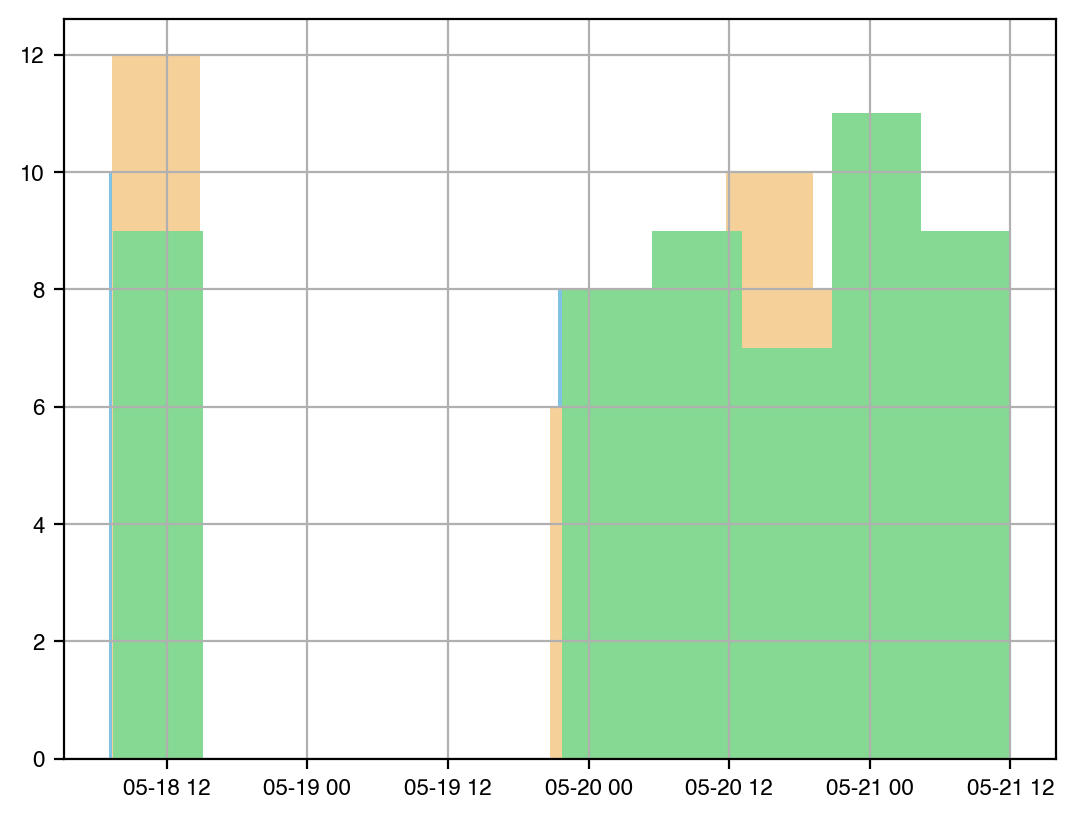

In [579]:
for arch in ['deformable']:
    for distance in ['cos']:
        for backbone in ['densenet161', 'resnet50', 'vgg19']:
            subset = runsXevalXsweeps_acc_dogs.loc[(arch, distance, backbone)]
            pd.to_datetime(subset['start_time'], unit='s').hist()

In [489]:
runsXevalXsweeps_acc_dogs['end_time'] = pd.to_datetime(runsXevalXsweeps_acc_dogs['start_time'] + runsXevalXsweeps_acc_dogs['actual_runtime'], unit='s')
runsXevalXsweeps_acc_dogs['end_time'].describe(), pd.to_datetime(runsXevalXsweeps_acc_dogs['start_time'], unit='s').describe(), 

(count                              270
 mean     2024-05-19 07:33:49.231441664
 min      2024-05-17 03:08:14.208025088
 25%      2024-05-18 00:39:45.838383616
 50%      2024-05-18 15:05:13.528027648
 75%      2024-05-20 18:15:49.771123968
 max      2024-05-21 15:46:28.400145920
 Name: end_time, dtype: object,
 count                              270
 mean     2024-05-19 03:52:35.451851776
 min                2024-05-17 01:17:27
 25%      2024-05-17 21:21:10.750000128
 50%         2024-05-18 11:58:04.500000
 75%                2024-05-20 13:40:46
 max                2024-05-21 12:03:32
 Name: start_time, dtype: object)

In [536]:
pre_stop_condition = pd.to_datetime(runsXevalXsweeps_acc_dogs.loc['deformable']['start_time'], unit='s') < pd.to_datetime('2024-05-19 00:00:00')
pre_stop_dogs = runsXevalXsweeps_acc_dogs.loc['deformable'][pre_stop_condition]
post_stop_dogs = runsXevalXsweeps_acc_dogs.loc['deformable'][~pre_stop_condition]

pre_stop_dogs.shape, post_stop_dogs.shape

((31, 83), (120, 83))

In [544]:
pause_times = {}
for backbone, group in pre_stop_dogs.groupby('backbone'):
    last_four_runs = group.sort_values('end_time', ascending=False).head(4)
    pause_times[backbone] = pd.to_datetime(post_stop_dogs.loc['cos', backbone]['start_time'].min(), unit='s') - last_four_runs['end_time'].sort_values().iloc[0]

pause_times

{'densenet161': Timedelta('1 days 09:37:27.882669824'),
 'resnet50': Timedelta('1 days 10:58:03.228670976'),
 'vgg19': Timedelta('1 days 10:28:05.435126016')}

<Axes: >

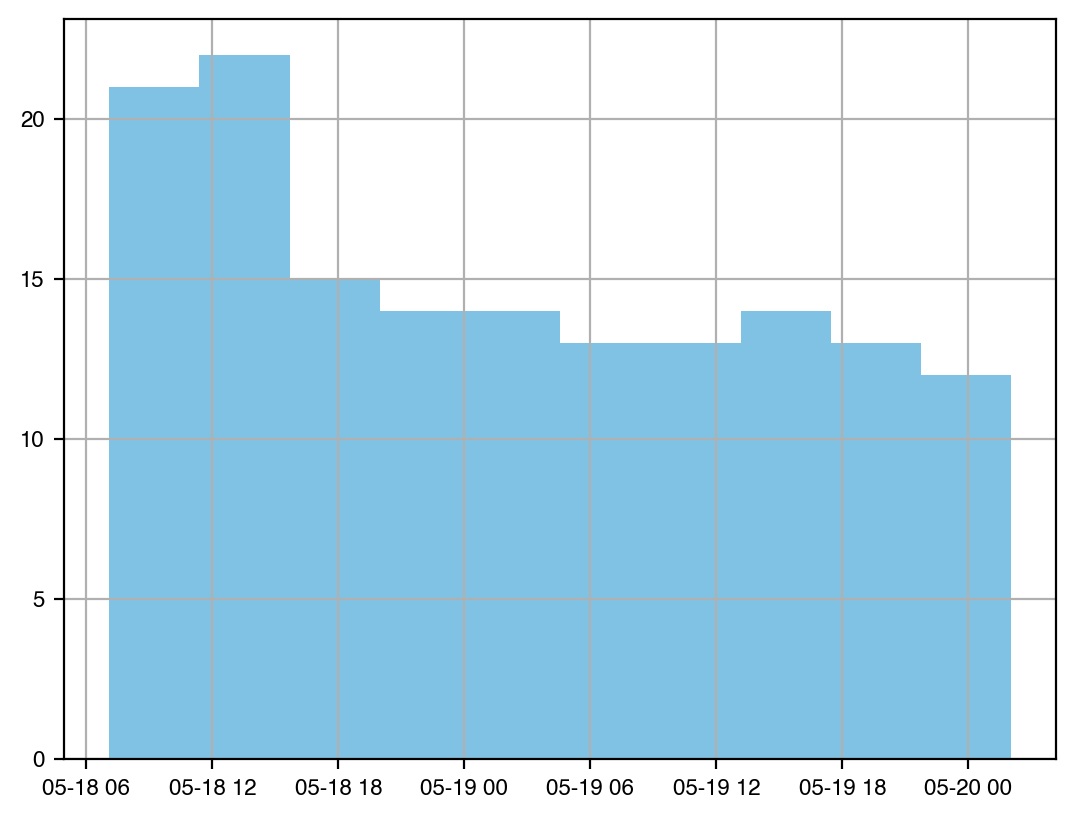

In [556]:
pre_stop_dogs['nominal_start_time'] = pd.to_datetime(pre_stop_dogs['start_time'], unit='s')

post_stop_dogs_temp = pd.DataFrame()
for backbone, group in post_stop_dogs.groupby('backbone'):
    group['nominal_start_time'] = pd.to_datetime(group['start_time'], unit='s') - pause_times[backbone]
    post_stop_dogs_temp = pd.concat([post_stop_dogs_temp, group])

retimed_dogs = pd.concat([pre_stop_dogs, post_stop_dogs_temp])
retimed_dogs['nominal_start_time'].hist()

In [573]:
dogs_in_window = pd.DataFrame()
for backbone, group in retimed_dogs.groupby('backbone'):
    after_cutoff = (group['nominal_start_time'] - pd.to_datetime(group['start_time'], unit='s').min()) > pd.Timedelta(hours=36)
    dogs_in_window = pd.concat([dogs_in_window, group[~after_cutoff]])

dogs_in_window.groupby('backbone').count()

run_id  name_run  sweep_id  timestamp  save_path  url_run  \
backbone                                                                 
densenet161      38        38        38         28         28       38   
resnet50         48        48        48         22         22       48   
vgg19            46        46        46         34         34       46   

             objective  objective_value  multiplier  step@best_step  ...  \
backbone                                                             ...   
densenet161         38                0          38              38  ...   
resnet50            48                0          48              48  ...   
vgg19               46                0          46              46  ...   

             name_sweep  program  project  url_sweep  best_run_id  \
backbone                                                            
densenet161          38       38       38         38           38   
resnet50             48       48       48         48           48   
vgg19                46       46       46         46           46   

             schedule_adjust  Unnamed: 0_y  actual_runtime  end_time  \
backbone                                                               
densenet161               38            38              38        38   
resnet50                  48            48              48        48   
vgg19                     46            46              46        46   

             nominal_start_time  
backbone                         
densenet161                  38  
resnet50                     48  
vgg19                        46  

[3 rows x 84 columns]

In [582]:
final_dogs = pd.concat([runsXevalXsweeps.loc['dogs', 'accuracy', 'vanilla'], dogs_in_window], keys=['vanilla', 'deformable'], names=['arch'])
final_dogs

run_id  \
arch       distance backbone                
vanilla    cos      densenet161  jddndoat   
                    densenet161  9m8ojv3d   
                    densenet161  t7mo1ex9   
                    densenet161  et5hti3k   
                    densenet161  a7t8u09o   
...                                   ...   
deformable cos      vgg19        dpvacovy   
                    vgg19        71shj5af   
                    vgg19        obtl9yi9   
                    vgg19        rvo1kqux   
                    vgg19        g300xgn4   

                                                                          name_run  \
arch       distance backbone                                                         
vanilla    cos      densenet161  cc--1.4E+00_im-False_jlss-5_lc-4.2E-04_ldme--2...   
                    densenet161  cc--1.3E+00_im-False_jlss-4_lc-8.8E-04_ldme--3...   
                    densenet161  cc--1.8E+00_im-False_jlss-3_lc-1.3E-05_ldme--1...   
                    densenet161  cc--1.3E+00_im-False_jlss-4_lc-2.0E-04_ldme-0_...   
                    densenet161  cc--1.4E+00_im-False_jlss-3_lc-4.9E-04_ldme-0_...   
...                                                                            ...   
deformable cos      vgg19        cc--1.6E+00_im-False_jlss-5_kft-5_lc-1.4E-04_l...   
                    vgg19        cc--1.1E+00_im-False_jlss-5_kft-9_lc-6.4E-05_l...   
                    vgg19        cc--7.8E-01_im-False_jlss-6_kft-6_lc-3.9E-04_l...   
                    vgg19        cc--1.2E+00_im-False_jlss-9_kft-8_lc-6.8E-04_l...   
                    vgg19        cc--1.8E+00_im-False_jlss-4_kft-4_lc-4.6E-04_l...   

                                 sweep_id            timestamp  \
arch       distance backbone                                     
vanilla    cos      densenet161  gx6v51ma  2024-05-18 10:30:14   
                    densenet161  gx6v51ma  2024-05-18 09:01:08   
                    densenet161  gx6v51ma  2024-05-18 07:47:27   
                    densenet161  gx6v51ma  2024-05-18 05:11:34   
                    densenet161  gx6v51ma                  NaN   
...                                   ...                  ...   
deformable cos      vgg19        87hmid8s  2024-05-20 00:45:21   
                    vgg19        87hmid8s  2024-05-19 22:42:20   
                    vgg19        87hmid8s  2024-05-19 22:07:42   
                    vgg19        87hmid8s  2024-05-19 22:12:02   
                    vgg19        87hmid8s  2024-05-19 23:01:20   

                                                                         save_path  \
arch       distance backbone                                                         
vanilla    cos      densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/gx6...   
                    densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/gx6...   
                    densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/gx6...   
                    densenet161  /usr/xtmp/ppnxt/neurips2024/live/artifacts/gx6...   
                    densenet161                                                NaN   
...                                                                            ...   
deformable cos      vgg19        /usr/xtmp/ppnxt/neurips2024/live/artifacts/87h...   
                    vgg19        /usr/xtmp/ppnxt/neurips2024/live/artifacts/87h...   
                    vgg19        /usr/xtmp/ppnxt/neurips2024/live/artifacts/87h...   
                    vgg19        /usr/xtmp/ppnxt/neurips2024/live/artifacts/87h...   
                    vgg19        /usr/xtmp/ppnxt/neurips2024/live/artifacts/87h...   

                                                                           url_run  \
arch       distance backbone                                                         
vanilla    cos      densenet161  https://wandb.ai/protopnext/neurips-experiment...   
                    densenet161  https://wandb.ai/protopnext/neurips-experiment...   
        

In [583]:
indexless_dogs = final_dogs.reset_index()
dogs_val_best_idxs = indexless_dogs.groupby(['arch', 'distance', 'backbone'], dropna=False)['val.accuracy'].idxmax().copy().reset_index()

dogs_val_best = indexless_dogs.loc[dogs_val_best_idxs['val.accuracy']]
dogs_val_best['selection'] = 'val'
dogs_val_best[['run_id', 'val.accuracy', 'test.accuracy', 'backbone', 'arch', 'distance']]

run_id  val.accuracy  test.accuracy     backbone        arch distance
138  eyyqvdq9      0.825833       0.817716  densenet161  deformable      cos
159  a0tbrags      0.696667       0.681002     resnet50  deformable      cos
224  mih0r1n4      0.742500       0.742890        vgg19  deformable      cos
9    ixd1vtki      0.849167       0.854196  densenet161     vanilla      cos
48   y7uklims      0.679167       0.668182     resnet50     vanilla      cos
101  3mbe4cbw      0.785000       0.787646        vgg19     vanilla      cos

In [585]:
indexless_dogs = final_dogs.reset_index()
dogs_test_best = indexless_dogs.groupby(['arch', 'distance', 'backbone'], dropna=False)['test.accuracy'].max().copy().reset_index()

dogs_test_best['selection'] = 'val'
dogs_test_best[['test.accuracy', 'backbone', 'arch', 'distance']]

test.accuracy     backbone        arch distance
0       0.823427  densenet161  deformable      cos
1       0.685897     resnet50  deformable      cos
2       0.749417        vgg19  deformable      cos
3       0.854196  densenet161     vanilla      cos
4       0.674359     resnet50     vanilla      cos
5       0.787995        vgg19     vanilla      cos

In [586]:
# no other objectives for dogs

dogs_val_acc_best = dogs_val_best.pivot(index=['arch', 'distance', 'selection'], columns=['backbone'], values='test.accuracy')
dogs_test_acc_best = dogs_test_best.pivot(index=['arch', 'distance', 'selection'], columns=['backbone'], values='test.accuracy')

dogs_all_acc_best = pd.concat([
    dogs_val_acc_best,
    dogs_test_acc_best
])

__df = dogs_all_acc_best.reset_index()
__df['idx'] = __df['arch'].apply(prototype_type) + ' ' + __df['selection'].apply(lambda x: 'Best ' + x.capitalize())
__df = __df.set_index('idx').drop(columns=['arch', 'distance', 'selection']).rename(stylize, axis=1)

baselines = pd.DataFrame({
    "DenseNet-161": [84.1, 77.3, 86.5],
    "ResNet-50": [pd.NA, pd.NA, pd.NA],
    "VGG-19": [77.3, 73.6, 77.9],
}, index=["Baseline", "ProtoPNet", "Deformable ProtoPNet"])

dogs_acc_table = pd.concat([
    baselines,
    __df*100]
)

dogs_acc_table.sort_index(ascending=False)

/var/folders/4w/ynbtcwnd0yn_f4ph8d5wh4_r0000gn/T/ipykernel_35641/1120495795.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dogs_acc_table = pd.concat([


DenseNet-161  ResNet-50     VGG-19
Rigid Best Val           85.419583  66.818184  78.764570
Rigid Best Val           85.419583  67.435896  78.799534
ProtoPNet                77.300000        NaN  73.600000
Deformable ProtoPNet     86.500000        NaN  77.900000
Deformable Best Val      81.771564  68.100232  74.289042
Deformable Best Val      82.342654  68.589741  74.941725
Baseline                 84.100000        NaN  77.300000

In [365]:
# dogs_acc_table.to_latex('tables/dogs-acc.tex', formatters=[single_digit_formatter]*dogs_acc_table.shape[1])